# Bi-directional LSTM with a CRF layer 
For this part of the challenge, I chose to use a Bidirectional LSTM with a CRF layer. A Bidirectional LSTM model is an extension of the traditional LSTMs that can improve model performance on sequence classification problems. My initial experiments show that a Bidirectional LSTM with a CRF layer can produce better results compared to a simple unidirectional LSTM or a simple bidirectional-LSTM.

## Pre-processing the input data
For solving this part of the challenge I have used both of the provided datasets (sample.csv and res.csv). Actually, I have added an extra feature to the existing features inside “sample.csv”. This new feature in my final dataset which is named “res_num” is the number of resources used by an event. I have computed this feature based on the data inside "res.csv". 
Also, it is worth noting that in sample.csv, we have several features with zero values that I have deleted them before trining the model.
In my code, the default values for the "number of events we want to predict in the future" and the "number of past events we want to use to predict the future" are 5 and 20 respectively.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

In [2]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [3]:
# Importing the input data
dataset_train = pd.read_csv('https://raw.githubusercontent.com/hydradon/clever-challenge/master/seq/sample.csv')

# Visualizing the first 5 rows
dataset_train.sample(5)

,event_id,timestamp,class,f1,f2,f3,f3.1,f4,f5,f6,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
10968,822035,1530260911,1,1,7,16,1.924287,891,683,352.062500,...,2,0,0,0,0,0,0,0,0,0
8122,819189,1523527730,0,1,3,3,1.098612,27,24,25.000000,...,0,0,0,0,0,0,0,0,0,0
16397,827464,1539082106,1,1,6,23,2.687548,925,45,80.521739,...,1,0,0,0,0,0,0,0,0,0
9412,820479,1527065595,0,1,1,2,0.475803,47,35,1288.500000,...,0,0,0,0,0,0,0,0,0,0
11038,822105,1530524197,0,1,1,1,0.000000,9,1,1769.000000,...,1,0,0,0,0,0,0,0,0,0


In [4]:
# Making sure that we don't have NULL values
dataset_train.isnull().sum()

# Obtaining a general undrestanding about the data
(dataset_train == 0).all()

# Deleting features (columns) that always have a zero value (f11, f16, f19, f22 to f30)
dataset_train.drop(columns=["f11", "f16", "f19"] + ["f{}".format(num) for num in range(22,31)], inplace=True, errors='ignore')
dataset_train.sample(5)

,event_id,timestamp,class,f1,f2,f3,f3.1,f4,f5,f6,...,f9,f10,f12,f13,f14,f15,f17,f18,f20,f21
1567,812634,1506527299,0,1,1,1,0.000000,3,1,460.000000,...,1,682,118,9269,0,0.0,0.0,0.0,0.0,0
15141,826208,1537457671,1,1,13,66,3.605019,1546,149,82.878788,...,39,2009,2008,9367,1,1363.0,1363.0,0.0,0.0,1
15021,826088,1537373624,1,1,3,7,1.572837,73,0,583.428571,...,5,3060,574,9277,2,6863.5,6806.0,0.0,0.0,2
914,811981,1501747223,1,3,10,20,2.419370,80,8,21.350000,...,8,452,385,9240,0,0.0,0.0,0.0,0.0,0
3478,814545,1512991528,0,1,1,1,0.000000,1,1,438.000000,...,1,175,175,9404,1,45.0,45.0,0.0,0.0,1


In [5]:
# Reading the second dataset (res.csv)
auxiliary_data = pd.read_csv('https://raw.githubusercontent.com/hydradon/clever-challenge/master/seq/res.csv')
auxiliary_data.sample(5)

,event_id,res_id
452537,814573,15411142
845703,827242,15743050
463128,815031,15495740
143833,811067,15469253
767184,823519,15719766


In [6]:
refined_auxiliary = auxiliary_data.groupby('event_id')['res_id'].apply(list).reset_index(name='res_list')
refined_auxiliary['res_num'] = refined_auxiliary['res_list'].apply(lambda d: len(d))
refined_auxiliary.describe(percentiles=[.25, .5, .99])

,event_id,res_num
count,18308.000000,18308.000000
mean,820291.728698,47.049541
std,5305.197181,1377.870359
min,811067.000000,1.000000
25%,815705.750000,1.000000
50%,820297.500000,3.000000
99%,829296.930000,355.000000
max,829483.000000,171999.000000


In [7]:
# Merging "dataset_train" and "refined_auxiliary" datasets
merged_dataset = dataset_train.reset_index().merge(refined_auxiliary[["event_id","res_num"]], on="event_id", how="left").set_index("timestamp")

merged_dataset.sample(5)

,index,event_id,class,f1,f2,f3,f3.1,f4,f5,f6,...,f10,f12,f13,f14,f15,f17,f18,f20,f21,res_num
timestamp,,,,,,,,,,,,,,,,,,,,,
1509005059,2272,813339,0,2,3,4,1.320888,7,1,672.750000,...,3263,3158,9272,1,12687.0,12578.0,0.0,0.0,1,4.0
1521835910,7324,818391,0,1,1,1,0.000000,1,1,94.000000,...,69343,69325,9356,0,0.0,0.0,0.0,0.0,0,1.0
1517559395,4966,816033,1,1,1,3,0.581897,27,21,683.333333,...,579,576,9343,1,129.0,129.0,0.0,0.0,1,3.0
1521211436,6954,818021,1,1,3,5,1.347077,3,26,232.000000,...,15318,360,9276,1,39.0,32.0,0.0,0.0,1,5.0
1498656261,709,811776,0,1,1,17,2.122141,531,513,0.941176,...,6616,688,9258,0,0.0,0.0,0.0,0.0,0,17.0


In [8]:
# Feature selection
features = list(merged_dataset)[2:23]

merged_dataset = merged_dataset[features].astype(float)

merged_dataset.sample(5)

,class,f1,f2,f3,f3.1,f4,f5,f6,f7,f8,...,f10,f12,f13,f14,f15,f17,f18,f20,f21,res_num
timestamp,,,,,,,,,,,,,,,,,,,,,
1538138939,0.0,1.0,1.0,1.0,0.000000,4.0,0.0,332.000000,3.0,428.945266,...,1469.0,1395.0,9305.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1507641172,0.0,1.0,2.0,3.0,0.557042,0.0,228.0,2254.666667,14.0,109.681362,...,1226.0,1224.0,156.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1523271070,0.0,1.0,1.0,7.0,1.717414,7.0,20.0,334.000000,14.0,212.195513,...,70181.0,70163.0,9356.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
1529592036,0.0,1.0,1.0,1.0,0.000000,1.0,1.0,44.000000,4.0,288.033194,...,1243.0,1157.0,9602.0,1.0,561.0,406.0,0.0,0.0,1.0,1.0
1516266984,0.0,3.0,4.0,4.0,0.840941,30.0,40.0,223.000000,12.0,162.946710,...,4504.0,4458.0,16.0,1.0,230.0,201.0,0.0,0.0,1.0,4.0


In [9]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

cur_data = merged_dataset.copy()
encoder = LabelEncoder()
cur_data["class"] = encoder.fit_transform(cur_data["class"])

scaler = MinMaxScaler(feature_range=(0, 1))
cur_data[features] = scaler.fit_transform(cur_data[features])

# Using multiple features (predictors)
training_set_scaled = cur_data.to_numpy()

print('Shape of training set == {}.'.format(training_set_scaled.shape))
training_set_scaled

Shape of training set == (18417, 21).


array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.11111111e-01, 6.15119641e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 7.77777778e-01, 1.06477210e-01, ...,
        0.00000000e+00, 0.00000000e+00, 5.93088292e-02],
       ...,
       [0.00000000e+00, 1.11111111e-01, 1.84535892e-04, ...,
        0.00000000e+00, 8.33333333e-02, 2.32560844e-05],
       [0.00000000e+00, 1.11111111e-01, 1.23023928e-04, ...,
        0.00000000e+00, 8.33333333e-02, 1.16280422e-05],
       [0.00000000e+00, 1.11111111e-01, 6.15119641e-05, ...,
        0.00000000e+00, 8.33333333e-02, 5.81402109e-06]])

In [29]:
# Creating a data structure with 20 timestamps and 1 output
X = []
Y = []

# Number of events we want to predict in the future
n_future = 5
# Number of past events we want to use to predict the future
n_past = 20     

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X.append(training_set_scaled[i - n_past:i, 0:merged_dataset.shape[1] - 1])
    Y.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X, Y= np.array(X), np.array(Y)

print('X shape == {}.'.format(X.shape))
# the "class" that we want to predict
print('Y shape == {}.'.format(Y.shape))

X shape == (18393, 20, 20).
Y shape == (18393, 1).


In [30]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

## Creating and training the model

In [31]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Flatten
from keras.optimizers import Adam
from keras.metrics import Precision
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras.layers import Bidirectional

In [32]:
# Initializing the Neural Network
model = Sequential()

# Adding a Bidirectional LSTM layer 
# Note we have multiple features (20 different features in our specific case)
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(n_past, merged_dataset.shape[1]-1)))

# Adding a CRF layer
model.add(CRF(units=2, learn_mode='marginal', input_shape=(n_past, merged_dataset.shape[1]-1)))

# Adding Dropout - To prevent over-fitting
model.add(Dropout(0.25))

# Flatting the data before entering to the output layar
model.add(Flatten())

# Output layer
# Note: In keras, the default activation of the lstm layer is "tanh" which has the range (-1, 1). 
# Since I want to use binary_crossentropy loss, I have changed the activation of the last layer to 
# "sigmoid" to prevent getting nan for loss.
model.add(Dense(1, activation='sigmoid'))

# Printing the model summary 
model.summary()

# Compiling the Neural Network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Precision(),'accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 20, 128)           43520     
_________________________________________________________________
crf_3 (CRF)                  (None, 20, 2)             266       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 2)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total params: 43,827
Trainable params: 43,827
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(x_train, y_train, shuffle=True, epochs=10, validation_data=(x_test, y_test), validation_split=0.2, verbose=1, batch_size=256)

Train on 14725 samples, validate on 3682 samples
Epoch 1/10
14725/14725 [==============================] - 19s 1ms/step - loss: 0.7356 - precision_2: 0.4639 - accuracy: 0.5315 - val_loss: 0.6847 - val_precision_2: 0.5000 - val_accuracy: 0.5519
Epoch 2/10
14725/14725 [==============================] - 12s 798us/step - loss: 0.7033 - precision_2: 0.4701 - accuracy: 0.5290 - val_loss: 0.6823 - val_precision_2: 0.5082 - val_accuracy: 0.5532
Epoch 3/10
14725/14725 [==============================] - 11s 750us/step - loss: 0.7035 - precision_2: 0.4682 - accuracy: 0.5273 - val_loss: 0.6815 - val_precision_2: 0.5058 - val_accuracy: 0.5527
Epoch 4/10
14725/14725 [==============================] - 11s 738us/step - loss: 0.7015 - precision_2: 0.4658 - accuracy: 0.5253 - val_loss: 0.6811 - val_precision_2: 0.5035 - val_accuracy: 0.5538
Epoch 5/10
14725/14725 [==============================] - 11s 716us/step - loss: 0.6985 - precision_2: 0.4824 - accuracy: 0.5364 - val_loss: 0.6805 - val_precision_2

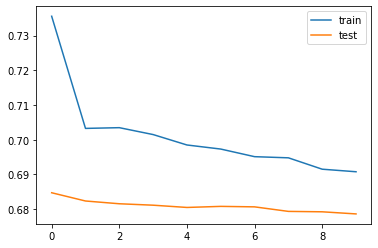

In [25]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [26]:
scores_stats = []
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))

precision_2: 50.31%
accuracy: 55.32%


# Making future predictions

In [27]:
# make a prediction
y_predict = model.predict(x_test)
y_test = y_test.reshape(len(y_test))
y_predict = y_predict.round().reshape(len(y_predict))

In [28]:
from sklearn.metrics import precision_score, recall_score
print("Precision: {:.2f} %".format(precision_score(y_test, y_predict) * 100))
print("Recall: {:.2f} %".format(recall_score(y_test, y_predict) * 100))

Precision: 50.31 %
Recall: 24.55 %
